<a href="https://colab.research.google.com/github/mbibrahe/BA_Project/blob/main/DBSCAN_bgSub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
 import tensorflow as tf
#tf.compat.v1.enable_eager_execution()


In [3]:
#!ls */train/*

In [4]:
from __future__ import print_function
import glob, os, numpy as np
from keras.preprocessing import image as kImage
from __future__ import print_function
import numpy as np
import random as rn
import os
from tensorflow.compat.v1.keras import backend as K




In [5]:
''
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



In [6]:

"""download = drive.CreateFile({'id': '1MUOVUdNCDTHA0FuHo4IsONhxSLLMxdZ7'})
download.GetContentFile("a2_n.zip")"""


download = drive.CreateFile({'id': '18lyftJ3H4avwQ8eJ7Wg9UFI4WgjFoOf6'})
download.GetContentFile("31_samples.zip")


#! unzip a2_n.zip
! unzip 31_samples.zip

from google.colab import drive
drive.mount ('/content/drive')

Streaming output truncated to the last 5000 lines.
  inflating: 31_samples/train/y/31/gt001379.png  
  inflating: 31_samples/train/y/31/gt001380.png  
  inflating: 31_samples/train/y/31/gt001381.png  
  inflating: 31_samples/train/y/31/gt001382.png  
  inflating: 31_samples/train/y/31/gt001383.png  
  inflating: 31_samples/train/y/31/gt001384.png  
  inflating: 31_samples/train/y/31/gt001385.png  
  inflating: 31_samples/train/y/31/gt001386.png  
  inflating: 31_samples/train/y/31/gt001387.png  
  inflating: 31_samples/train/y/31/gt001388.png  
  inflating: 31_samples/train/y/31/gt001389.png  
  inflating: 31_samples/train/y/31/gt001390.png  
  inflating: 31_samples/train/y/31/gt001391.png  
  inflating: 31_samples/train/y/31/gt001392.png  
  inflating: 31_samples/train/y/31/gt001393.png  
  inflating: 31_samples/train/y/31/gt001394.png  
  inflating: 31_samples/train/y/31/gt001395.png  
  inflating: 31_samples/train/y/31/gt001396.png  
  inflating: 31_samples/train/y/31/gt001397.png  

In [20]:
import numpy as np

import keras
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, AveragePooling2D, GlobalAveragePooling3D
from keras.models import Sequential
from keras.layers.convolutional import Deconv2D, Conv2DTranspose
from keras.layers import Activation, Input, Dropout, BatchNormalization, SpatialDropout2D, LayerNormalization
from keras.layers.merge import concatenate
import keras.backend as K
import tensorflow as tf
from keras import regularizers
from PIL import Image as PILimage
import matplotlib.pyplot as plt
from matplotlib import image as imageMat
from keras import backend as K
from sklearn.datasets import load_sample_image
from sklearn.feature_extraction import image as Image
from sklearn.datasets import load_sample_image
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
import cv2 as cv


import sys, time

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS

# Load images into array as graycale 320*240
dataset_path = os.path.join('31_samples')
def getData(dataset_dir):
    X_list11= sorted(glob.glob(os.path.join(dataset_dir, 'train', 'x','9','*.jpg')))
    #X_list2= sorted(glob.glob(os.path.join(dataset_dir, 'train', 'x','11','*.jpg')))


    X_gray= []
    X= []



    #Run for less frames
    for i in range(0,499):
        # Load input image
        
        x_gray = cv.resize(cv.imread(X_list11[i], 0), (320, 240))
        x_gray = cv.normalize(x_gray, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
        X_gray.append(x_gray)



        x = cv.resize(cv.imread(X_list11[i]), (320, 240))
        normalizedImg = np.zeros((320, 240))
        normalizedImg = cv.normalize(x,  normalizedImg, 0, 255, cv.NORM_MINMAX)
        X.append(normalizedImg)

    X_gray = np.asarray(X_gray)
    X = np.asarray(X)

    return X_gray, X

X_gray, X = getData(dataset_path)

print(X_gray[0].shape)

(240, 320)


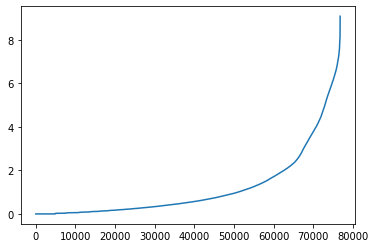

4.985359692375362
Running DBSCAN...
Progress: 240/240 [########################################] Done! (Time: 00 hr 08 min)


In [21]:

import heapq
import statistics
from collections import Counter

def nn_epsilon(frames):

  #We find the optimal value for epsilon, using k-nearest neighbor.
  #Reshaping (flattening) the grayscale 3d array, into a 2d array
  #nsamples, nx, ny = frames.shape
  #d2_X = frames.reshape((nsamples,nx*ny))
  #print(d2_X.shape)
  temp_ = []

  #We find the nearest 2 neighbors for each pixel in the same frame.
  #Returns the 2 indices of the nearest 2 neighbors, aswell as the euclidean distance (in a straight line) to those neighbors.
  #We run for n frames, appending the max euclidean distances to the 2nd neighbor (the neighbor which is not itself)




  shape = (len(frames), len(frames[0]), len(frames[0][0]))
    

   
  #iterate through rows
  for r in range(0, shape[1]):
      row = []
      #iterate through cols
      for c in range(0, shape[2]):

          #Create temp array of current r, c pixel for EVERY frame in the original video.
          #This means, we create an array of length 200, where each element is the rgb values, 
          #for pixel at location 1,1, then at location 1,2 and so on.
          pixels = np.array([frame[r][c] for frame in frames])
          #print(pixels)
            
          # Compute the means
          #pixels = pixels.reshape(-1, 1)
          nbrs = NearestNeighbors(n_neighbors=2).fit(pixels)
          distances, indices = nbrs.kneighbors(pixels)
          distances = distances[:,1]
          top_distances = heapq.nlargest(round(len(distances)/8), distances)
          temp_.append(sum(top_distances)/len(top_distances))
  
  temp_arr = np.array(temp_)
  #We sort the average euclidean distances in ascending order 
  temp_arr = np.sort(temp_arr, axis=0)
  #print(temp_arr)
  plt.plot(temp_arr)
  plt.show()

  #We approach the point of maximum curvature (elbow)
  ####### IS THIS NECESSARY ########## 
  dif_ = [j-i for i, j in zip(temp_arr[:-1], temp_arr[1:])]

  #Zip original distances with dif_, and find the distance with largest dif_
  avg_dif = sum(dif_)/len(dif_)
  n_zip = zip(temp_arr, dif_)
  tip_ = []
  for x, y in n_zip:
    if (y > avg_dif):
      tip_.append(x)
  #print(len(tip_))
  list_of_max = heapq.nlargest(round(len(tip_)/2), tip_)
  avg_max_dif = sum(list_of_max)/len(list_of_max)
  
  
  #plt.plot(temp_arr)
  #plt.show()
  return avg_max_dif
#nn_epsilon(X_gray)

#Code for fix_photo:
#https://github.com/vimlord/Clustering-Background-Subtraction


#Epsilon is the maximum distance between to samples, for them to be clustered in the same neighborhood
#Min_points is the minimum number of samples in a neighborhood for a data point to qualify as a core point 
#Frames = out dataset, eps = the optimal calculated epsilon, minPts = dataset dim*2
def fix_photo(frames, grey_frames, eps=0.00, minPts = 6):
    eps_ = nn_epsilon(grey_frames)
    print(eps_)
    shape = (len(frames), len(frames[0]), len(frames[0][0]))
    #print("shape1 = " + str(len(shape[1])))
    image = []

    bar_width = 40
    bar_prog = 0
    start = time.time()
    
    sys.stdout.write("Running DBSCAN...\nProgress: 0/" + str(shape[1]) + " [" + (bar_width * " ") + "] ETA: N/A")
    sys.stdout.flush()
    #iterate through rows
    for r in range(0, shape[1]):
        row = []
        #iterate through cols
        for c in range(0, shape[2]):

            #Create temp array of current r, c pixel for EVERY frame in the original video.
            #This means, we create an array of length 200, where each element is the rgb values, 
            #for pixel at location 1,1, then at location 1,2 and so on.
            pixels = np.array([frame[r][c] for frame in frames])
            #print(pixels)
            
            # Compute the means
            
            db = DBSCAN(eps=eps_, min_samples=minPts).fit(pixels)

            
            
            # Grab label information.
            labels = db.labels_
            #print(Counter(labels))
            label_set = set(labels)
            label_count = {l : 0 for l in label_set}
            
            # Compute label frequency
            for l in labels:
                label_count[l] += 1
            
            # Choose a cluster.
            choice = None
            for l in label_set:
                if choice is None or label_count[choice] < label_count[l] and l != -1:
                    choice = l
            
            # Apply the pixel if it exists.
            if choice is None:
                row.append(np.mean(pixels, axis=0))
            else:
                row.append(np.mean(np.array([pixels[i] for i in range(len(labels)) if labels[i] == choice]), axis=0))
                   
        # Provide the image
        image.append(row)
        
        # Bar progress
        bar_prog = int((bar_width * (r+1.)) / shape[1])
        
        # Time remaining
        t = time.time() - start
        t = (shape[1] * t / (r+1.0)) - t

        sys.stdout.write("\rProgress: " + str(r+1) + "/" + str(shape[1]) + " [" + ("#" * bar_prog) + (" " * (bar_width - bar_prog)) + "] ETA: ")
        sys.stdout.write(time.strftime("%H hr %M min", time.gmtime(t)))
        sys.stdout.flush()

    sys.stdout.write("\rProgress: " + str(shape[1]) + "/" + str(shape[1]) + " [" + ("#" * bar_prog) + (" " * (bar_width - bar_prog)) + "] Done! ")

    print(time.strftime("(Time: %H hr %M min)", time.gmtime(time.time() - start)))

    return image



res = np.array(fix_photo(X, X)).astype(np.uint8)





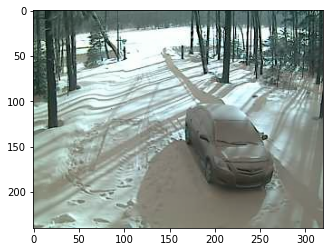

In [22]:
plt.imshow(res)
plt.show()

In [10]:
cv.imwrite ('/content/drive/My Drive/bg31.jpg', res)

True